# **Chapter 8**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## **#3.**

In [ ]:
X = np.linspace(0, 1, 101)
G = 2*X*(1-X)
D = -X*np.log(X)-(1-X)*np.log(1-X)
E = 1-np.maximum(X, 1-X)

<ipython-input-2-5d43c6b49ce3>:3: RuntimeWarning: divide by zero encountered in log
  D = -X*np.log(X)-(1-X)*np.log(1-X)
<ipython-input-2-5d43c6b49ce3>:3: RuntimeWarning: invalid value encountered in multiply
  D = -X*np.log(X)-(1-X)*np.log(1-X)


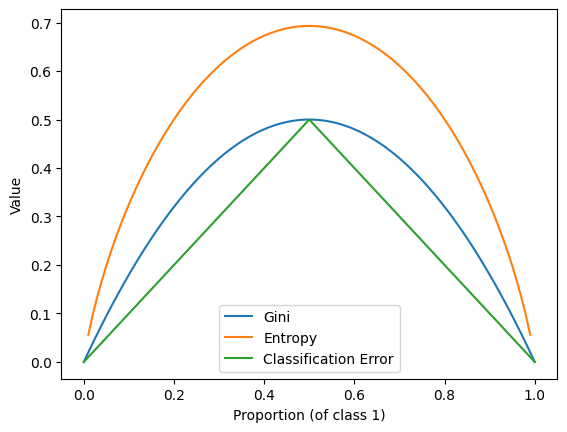

In [ ]:
plt.plot(X, G, label='Gini')
plt.plot(X, D, label='Entropy')
plt.plot(X, E, label='Classification Error')
plt.xlabel('Proportion (of class 1)')
plt.ylabel('Value')
plt.legend()

## **#8.**

In [ ]:
!pip install bayesian-forest

ERROR: Could not find a version that satisfies the requirement bayesian-forest (from versions: none)
ERROR: No matching distribution found for bayesian-forest


In [15]:
import pandas as pd
import numpy as np
import pydotplus  # Check the references if you need help to install this module.
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor, export_graphviz  # References: download link and instructions to install Graphviz.
from IPython.display import Image  # To plot decision tree.
from six import StringIO
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

In [16]:
cd /content/drive/MyDrive/MAS456_컴퓨터통계방법론

/content/drive/MyDrive/MAS456_컴퓨터통계방법론


In [17]:
df = pd.read_csv('./Carseats.csv')

In [18]:
df.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [19]:
# Transforom qualitatve variables into quantitative to enable the use of regressor

df = pd.get_dummies(df)

In [20]:
df.head()

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc_Bad,ShelveLoc_Good,ShelveLoc_Medium,Urban_No,Urban_Yes,US_No,US_Yes
0,9.50,138,73,11,276,120,42,17,1,0,0,0,1,0,1
1,11.22,111,48,16,260,83,65,10,0,1,0,0,1,0,1
2,10.06,113,35,10,269,80,59,12,0,0,1,0,1,0,1
3,7.40,117,100,4,466,97,55,14,0,0,1,0,1,0,1
4,4.15,141,64,3,340,128,38,13,1,0,0,0,1,1,0


In [21]:
# This function creates images of tree models using pydot
# Source: http://nbviewer.jupyter.org/github/JWarmenhoven/ISL-python/blob/master/Notebooks/Chapter%208.ipynb
# The original code used pydot instead of pydotplus. We didn't change anything else.
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names

    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return(graph)


### **(a)**

In [22]:
# Split data into training and test set
X = df.iloc[:,1:]
y = df['Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=1)

### **(b)**

In [23]:
# Fit regression tree
rgr = DecisionTreeRegressor()  # We could have chosen another max_depth value.
rgr.fit(X_train, y_train)

DecisionTreeRegressor()

In [24]:
# Plot the tree
graph = print_tree(rgr, features=list(X_train.columns.values))
Image(graph.create_png())

Output hidden; open in https://colab.research.google.com to view.

In [25]:
# Test MSE
print('Test MSE: ', mean_squared_error(y_test, rgr.predict(X_test)))

Test MSE:  5.990749166666666


In [ ]:
# For comparison, here is the baseline test MSE
# (Using the average y_train as the prediction for all y_test)
baseline_test_pred = np.mean(y_train)
print('Baseline test MSE: ', np.mean((y_test - baseline_test_pred)**2))

Baseline test MSE:  7.855167833333334


### **(c)**

In [ ]:
# Run grid search
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=1),
                           param_grid={'max_depth':[1,2,3,4,5,6,7,8,9,10]},
                           cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=1),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]})

In [ ]:
# Using cross-validation in order to
print(grid_search.best_estimator_)

DecisionTreeRegressor(max_depth=5, random_state=1)


In [ ]:
# fit a tree accordning to optimal level of complexity obtained above
rgr = DecisionTreeRegressor(max_depth=5)
rgr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5)

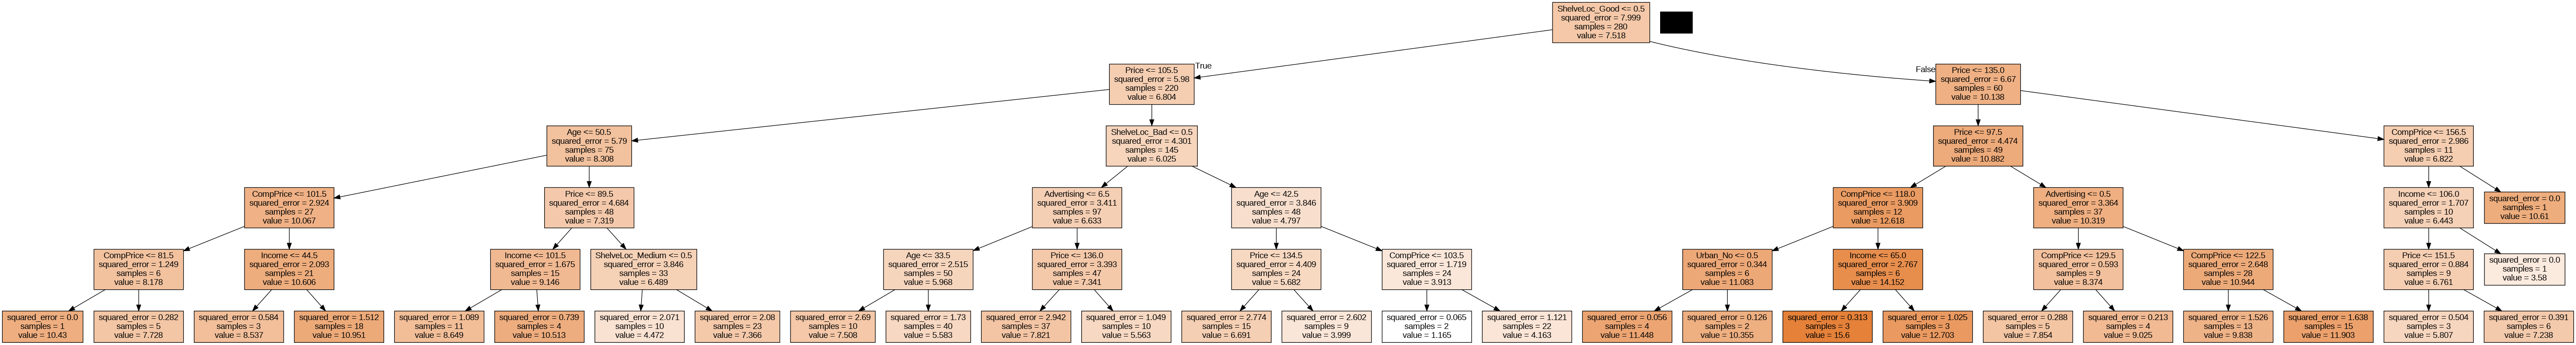

In [ ]:
graph = print_tree(rgr, features=list(X_train.columns.values))
Image(graph.create_png())

In [ ]:
# Test MSE before pruning
print('Test MSE: ', mean_squared_error(y_test, rgr.predict(X_test)))

Test MSE:  5.564392896935154


In [ ]:
pruning_parameters = np.linspace(0, 1, 1001)

best_mean_squared_error = float('inf')
best_pruning_param = None

# Iterate over each pruning parameter and perform cross-validation
for param in pruning_parameters:
    regressor = DecisionTreeRegressor(ccp_alpha=param)
    # Perform 5-fold cross-validation, you can change the number of folds (cv) as needed
    scores = -cross_val_score(regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mean_mse = np.mean(scores)
    if mean_mse < best_mean_squared_error:
        best_mean_squared_error = mean_mse
        best_pruning_param = param

# Train a decision tree regressor with the best pruning parameter on the entire training set
best_regressor = DecisionTreeRegressor(ccp_alpha=best_pruning_param)
best_regressor.fit(X_train, y_train)

# Evaluate the best model on the test set
y_pred = best_regressor.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)

print("Best pruning parameter:", best_pruning_param)
print("Best cross-validation mean squared error:", best_mean_squared_error)
print("Test set mean squared error:", test_mse)

Best pruning parameter: 0.105
Best cross-validation mean squared error: 4.824893272941649
Test set mean squared error: 5.127302321273648


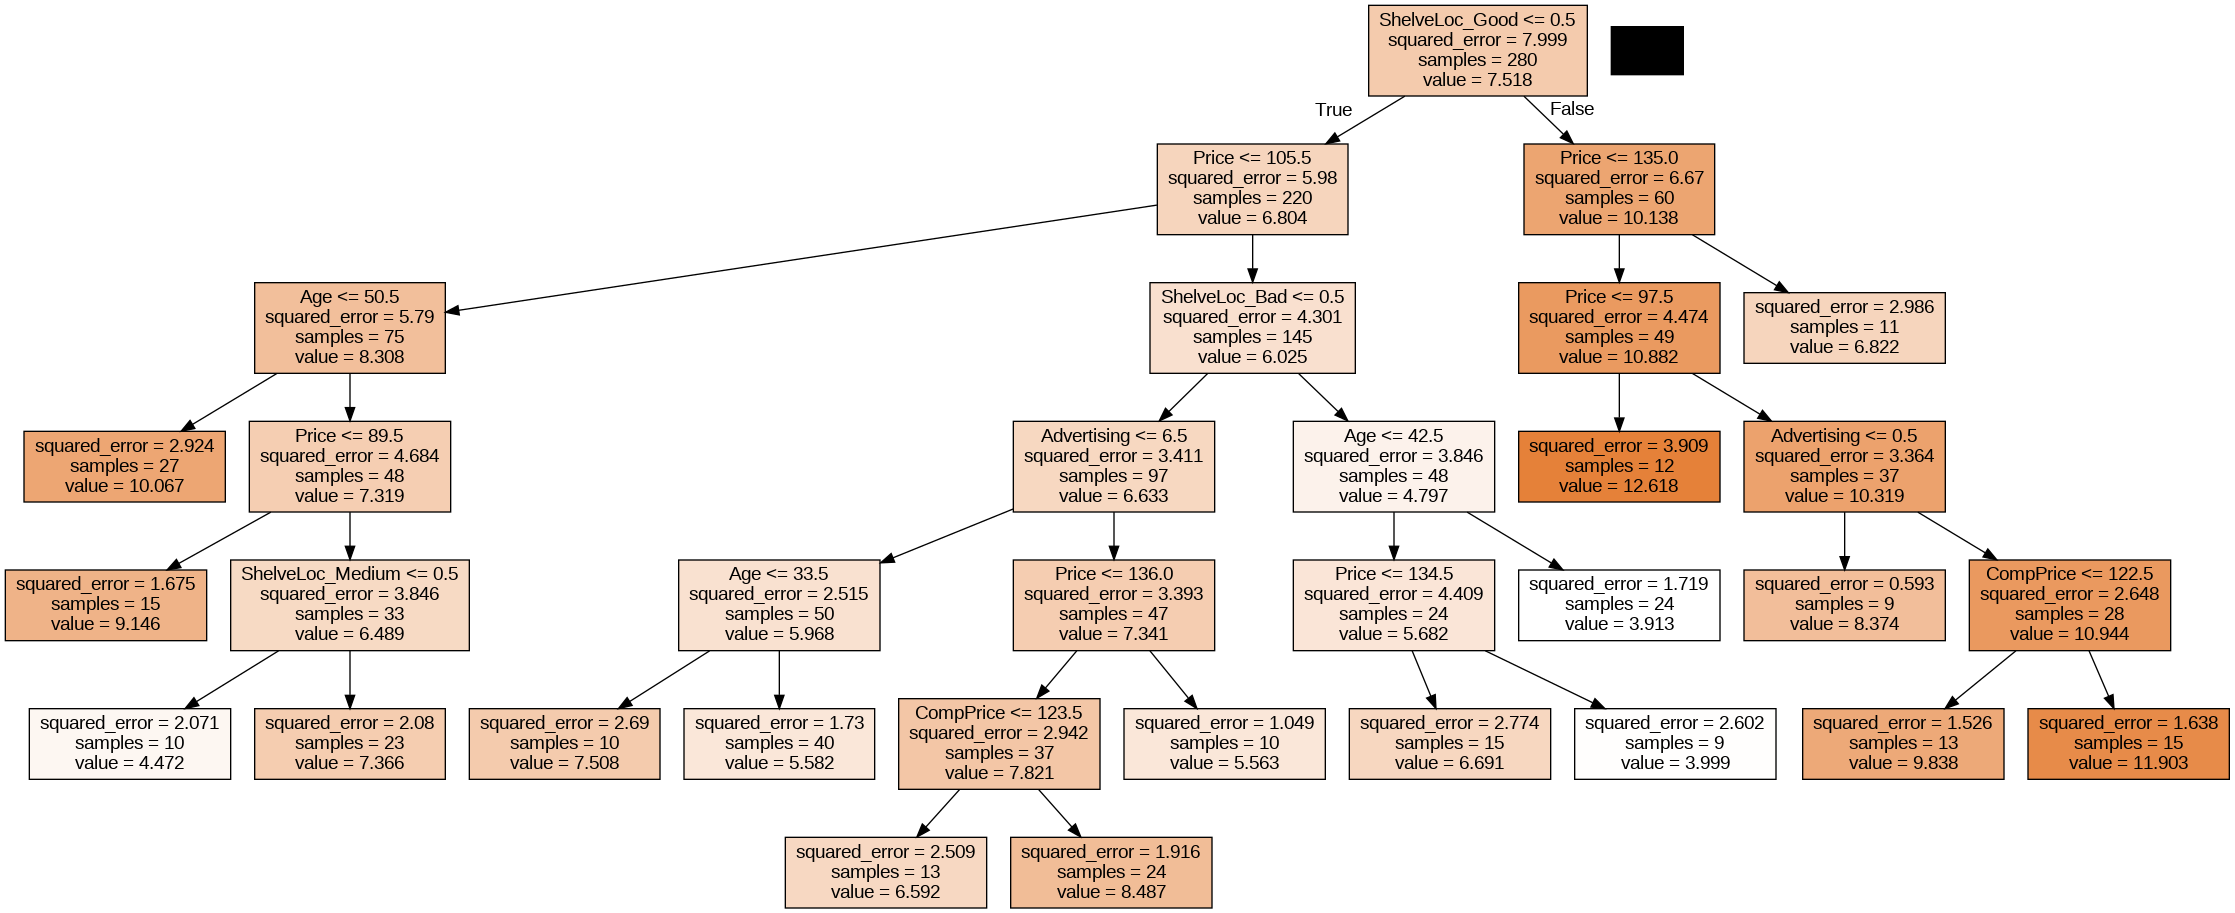

In [ ]:
graph = print_tree(best_regressor, features=list(X_train.columns.values))
Image(graph.create_png())

**Test MSE slightly decreased**

### **(d)**

In [ ]:
# Fit bagging regressor
rgr = BaggingRegressor()
rgr.fit(X_train, y_train)

BaggingRegressor()

In [ ]:
# Test MSE
print('Test MSE:', mean_squared_error(y_test, rgr.predict(X_test)))

Test MSE: 2.841430033333333


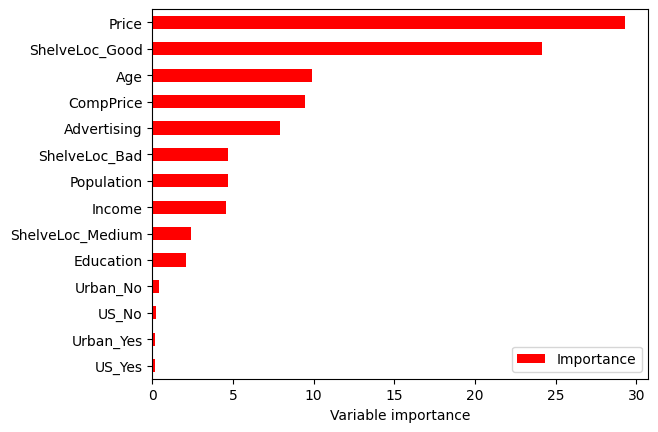

In [ ]:
feature_importances = np.mean([
    tree.feature_importances_ for tree in rgr.estimators_
], axis=0)

# Variable importance
importance = pd.DataFrame({'Importance':feature_importances*100}, index=X_train.columns)
importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r')
plt.xlabel('Variable importance')
plt.legend(loc='lower right')

### **(e)**

In [ ]:
# Fit random forest regressor
rgr = RandomForestRegressor()
rgr.fit(X_train, y_train)

RandomForestRegressor()

In [ ]:
# Test MSE
print('Test MSE:', mean_squared_error(y_test, rgr.predict(X_test)))

Test MSE: 2.8662048451666653


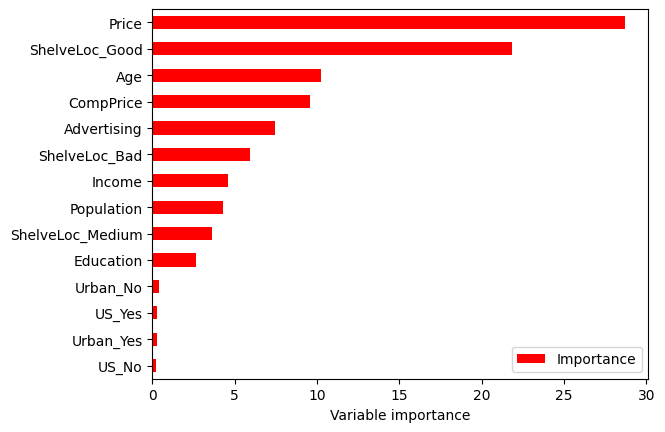

In [ ]:
# Variable importance
importance = pd.DataFrame({'Importance':rgr.feature_importances_*100}, index=X_train.columns)
importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r')
plt.xlabel('Variable importance')
plt.legend(loc='lower right')

### **(f)**

In [ ]:
pip install git+https://github.com/JakeColtman/bartpy.git --upgrade

  Cloning https://github.com/JakeColtman/bartpy.git to /tmp/pip-req-build-s2r134ay
  Running command git clone --filter=blob:none --quiet https://github.com/JakeColtman/bartpy.git /tmp/pip-req-build-s2r134ay
  Resolved https://github.com/JakeColtman/bartpy.git to commit 09e409e91dd1b9d44784c788c2d731dafb181eb0
  Preparing metadata (setup.py) ... done


In [ ]:
from bartpy.sklearnmodel import SklearnModel
bart_model = SklearnModel(n_trees=100, n_chains=4)

# Fit the BART model to the training data
bart_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = bart_model.predict(X_test)

# Calculate the test MSE
test_mse = mean_squared_error(y_test, y_pred)

print(f"Test Mean Squared Error (MSE): {test_mse:.2f}")

Test Mean Squared Error (MSE): 1.63


## **#11.**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [ ]:
df = pd.read_csv('./Caravan.csv')

In [ ]:
df.head()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,No
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,No
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,No
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,No
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,No


### **(a)**

In [ ]:
X = df.drop(columns=['Purchase'])
y = df['Purchase']

X_train = X.iloc[:1000, :]
X_test = X.iloc[1000:, :]
y_train = y.iloc[:1000]
y_test = y.iloc[1000:]

### **(b)**

In [ ]:
# Create a Gradient Boosting Classifier with 1000 trees and a shrinkage of 0.01
n_trees = 1000
shrinkage = 0.01
gb_classifier = GradientBoostingClassifier(n_estimators=n_trees, learning_rate=shrinkage, random_state=42)

# Fit the model to the training data
gb_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = gb_classifier.predict(X_test)

# Calculate accuracy to evaluate the model
accuracy = accuracy_score(y_test, y_pred)

print(f"Number of Trees: {n_trees}")
print(f"Shrinkage (Learning Rate): {shrinkage}")
print(f"Accuracy on Test Data: {accuracy:.2f}")

Number of Trees: 1000
Shrinkage (Learning Rate): 0.01
Accuracy on Test Data: 0.93


In [ ]:
(y_pred=='Yes').sum()

62

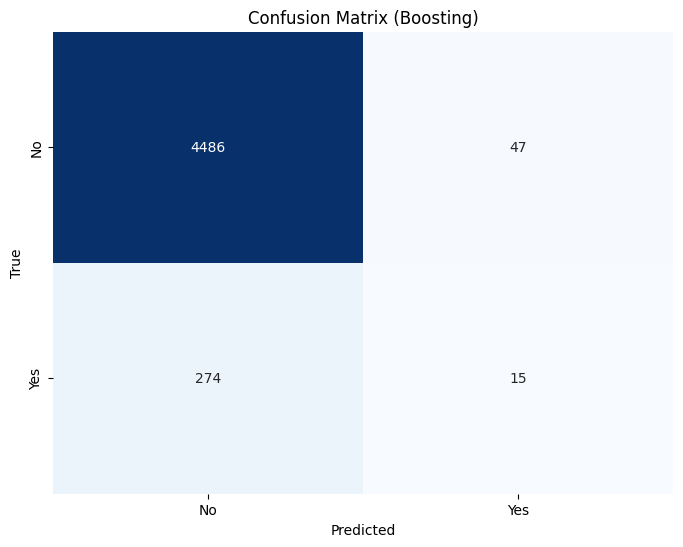

In [ ]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Boosting)')
plt.show()

In [ ]:
df.iloc[1000:, :].groupby('Purchase').count()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
Purchase,,,,,,,,,,,,,,,,,,,,,
No,4533,4533,4533,4533,4533,4533,4533,4533,4533,4533,...,4533,4533,4533,4533,4533,4533,4533,4533,4533,4533
Yes,289,289,289,289,289,289,289,289,289,289,...,289,289,289,289,289,289,289,289,289,289


In [ ]:
importance.sort_values('Importance', axis=0, ascending=False)

,Importance
Price,28.699002
ShelveLoc_Good,21.870956
Age,10.246927
CompPrice,9.561626
Advertising,7.443161
ShelveLoc_Bad,5.924173
Income,4.568179
Population,4.261458
ShelveLoc_Medium,3.639040
Education,2.627612


### **(c)**

In [ ]:
# Create a Gradient Boosting Classifier with 1000 trees and a shrinkage of 0.01
n_trees = 1000
shrinkage = 0.01
gb_classifier = GradientBoostingClassifier(n_estimators=n_trees, learning_rate=shrinkage, random_state=42)

# Fit the model to the training data
gb_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred_prob = gb_classifier.predict_proba(X_test)

# Revise prediction based on threshold probability 0.2
y_pred = ['Yes' if (item[1] > 0.2) else 'No' for item in y_pred_prob]

# Calculate accuracy to evaluate the model
accuracy = accuracy_score(y_test, y_pred)

print(f"Number of Trees: {n_trees}")
print(f"Shrinkage (Learning Rate): {shrinkage}")
print(f"Accuracy on Test Data: {accuracy:.2f}")

Number of Trees: 1000
Shrinkage (Learning Rate): 0.01
Accuracy on Test Data: 0.91


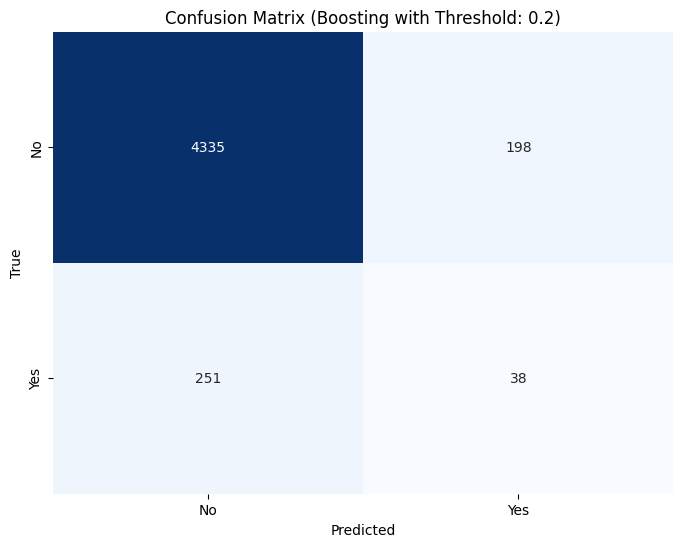

In [ ]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Boosting with Threshold: 0.2)')
plt.show()

**Comparison with KNN, Logistic Regression**

#### **KNN**

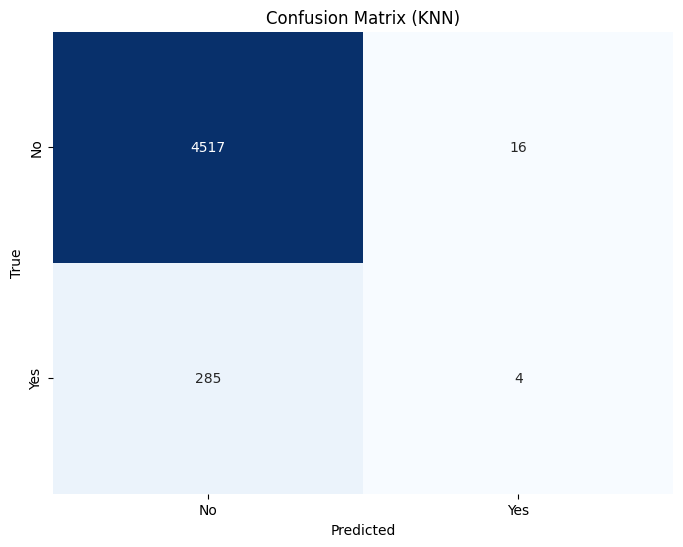

Best 'k' value: 4
              precision    recall  f1-score   support

          No       0.94      1.00      0.97      4533
         Yes       0.20      0.01      0.03       289

    accuracy                           0.94      4822
   macro avg       0.57      0.51      0.50      4822
weighted avg       0.90      0.94      0.91      4822



In [ ]:
param_grid = {'n_neighbors': range(1, 21)}

# Create a KNN classifier
knn_classifier = KNeighborsClassifier()

# Perform grid search with cross-validation to find the best 'k'
grid_search = GridSearchCV(knn_classifier, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best 'k' value from the grid search
best_k = grid_search.best_params_['n_neighbors']

# Create a KNN classifier with the best 'k' value
knn_classifier_best = KNeighborsClassifier(n_neighbors=best_k)
knn_classifier_best.fit(X_train, y_train)

# Make predictions on the test data
y_pred = knn_classifier_best.predict(X_test)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (KNN)')
plt.show()

# Print the best 'k' value and classification report
print(f"Best 'k' value: {best_k}")
print(classification_report(y_test, y_pred))

#### **Logistic Regression**

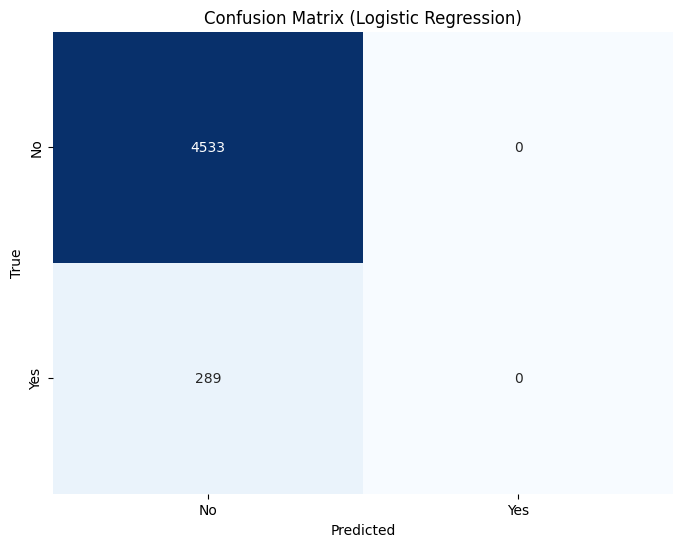

Best 'C' value: 0.001
              precision    recall  f1-score   support

          No       0.94      1.00      0.97      4533
         Yes       0.00      0.00      0.00       289

    accuracy                           0.94      4822
   macro avg       0.47      0.50      0.48      4822
weighted avg       0.88      0.94      0.91      4822



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Create a Logistic Regression classifier
logistic_classifier = LogisticRegression(solver='liblinear', random_state=42)

# Perform grid search with cross-validation to find the best hyperparameter 'C'
grid_search = GridSearchCV(logistic_classifier, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameter 'C' value from the grid search
best_C = grid_search.best_params_['C']

# Create a Logistic Regression classifier with the best 'C' value
logistic_classifier_best = LogisticRegression(C=best_C, solver='liblinear', random_state=42)
logistic_classifier_best.fit(X_train, y_train)

# Make predictions on the test data
y_pred = logistic_classifier_best.predict(X_test)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Logistic Regression)')
plt.show()

# Print the best 'C' value and classification report
print(f"Best 'C' value: {best_C}")
print(classification_report(y_test, y_pred))

# **Chapter 11**

##**#5.**

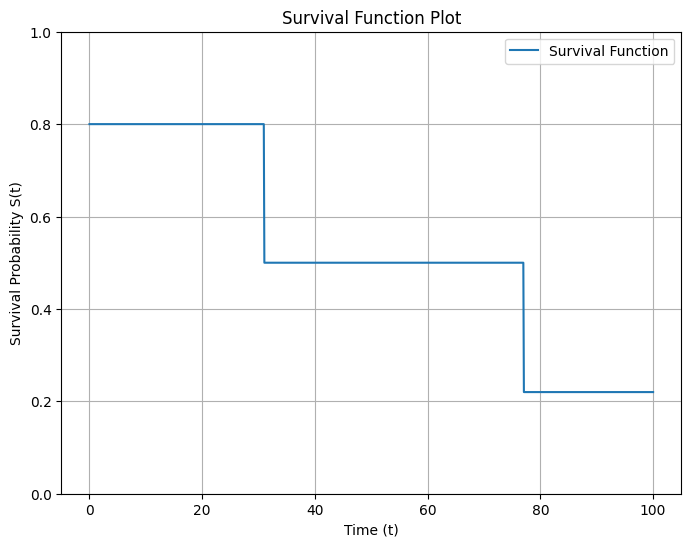

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the time values
t = np.linspace(0, 100, 1000)  # You can adjust the range and resolution as needed

# Define the survival function based on the given equation
S_t = np.piecewise(t, [t < 31, (t >= 31) & (t < 77), t >= 77], [0.8, 0.5, 0.22])

# Plot the survival function
plt.figure(figsize=(8, 6))
plt.plot(t, S_t, label='Survival Function')
plt.ylim(0, 1)
plt.xlabel('Time (t)')
plt.ylabel('Survival Probability S(t)')
plt.title('Survival Function Plot')
plt.grid(True)
plt.legend()
plt.show()

## **#11.**

In [2]:
!pip install lifelines

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.7/350.7 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 7.1 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=98a440f502cb44ef48645e7812b0271ab3daf9b6650ecbc4cab9c9d4849651e2
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


### **(a)**

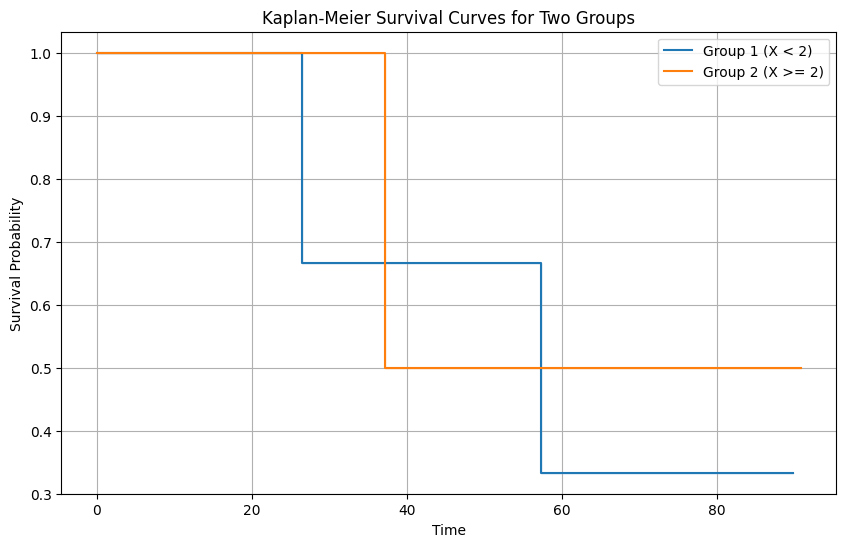

In [3]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Create a DataFrame with the given data
data = pd.DataFrame({
    'Y': [26.5, 37.2, 57.3, 90.8, 20.2, 89.8],
    'delta': [1, 1, 1, 0, 0, 0],
    'X': [0.1, 11, -0.3, 2.8, 1.8, 0.4]
})

# Define the groups based on the criteria (Group 1: X < 2, Group 2: X >= 2)
group_1 = data[data['X'] < 2]
group_2 = data[data['X'] >= 2]

# Create Kaplan-Meier estimators for each group
kmf_group_1 = KaplanMeierFitter(alpha=1)
kmf_group_2 = KaplanMeierFitter(alpha=1)

# Fit the Kaplan-Meier estimator to the data for each group
kmf_group_1.fit(group_1['Y'], event_observed=group_1['delta'], label='Group 1 (X < 2)')
kmf_group_2.fit(group_2['Y'], event_observed=group_2['delta'], label='Group 2 (X >= 2)')

# Plot the Kaplan-Meier survival curves
plt.figure(figsize=(10, 6))
kmf_group_1.plot()
kmf_group_2.plot()

plt.title('Kaplan-Meier Survival Curves for Two Groups')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.legend(loc='best')
plt.grid(True)
plt.show()


### **(b)**

In [26]:
from lifelines import CoxPHFitter

data['group'] = (data['X'] < 2).astype(int)

# Fit the Cox Proportional Hazards Model:
cph = CoxPHFitter()
cph.fit(data[['Y', 'delta', 'group']], duration_col='Y', event_col='delta')

# Extract the Coefficient:
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
group,0.340143,1.405149,1.235876,-2.082129,2.762416,0.124664,15.838061,0.0,0.275224,0.783144,0.352651


### **(c)**

In [5]:
from lifelines.statistics import logrank_test

group1 = data[data['group']==1]
group2 = data[data['group']==2]

In [6]:
# Run the Cox Proportional Hazards Model:
cph = CoxPHFitter()
cph.fit(data[['Y', 'delta', 'group']], duration_col='Y', event_col='delta')
cox_p_value = cph.summary.loc['group', 'p']

# Conduct the Log-Rank Test:
logrank_result = logrank_test(group1['Y'], group2['Y'], event_observed_A=group1['delta'], event_observed_B=group2['delta'])
logrank_p_value = logrank_result.p_value

# Compare the P-Values:
# Comparing the p-values
print("Cox Model p-value:", cox_p_value)
print("Log-Rank Test p-value:", logrank_p_value)

Cox Model p-value: 0.7831437750676561
Log-Rank Test p-value: 0.7821768255255889
